In [1]:
import random
import os
import numpy as np
import torch

def seed_everything(seed):
    """
    """
    # 1. Python & Numpy
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    # 2. PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"🔒 Locked Random Seed: {seed}")



In [2]:
import torch
import numpy as np
import random

def seed_everything_random():
    """
    Tạo random seed, set seed đó, và return seed để bạn biết
    """
    # Tạo random seed
    random_seed = random.randint(0, 999999)

    # Set seed
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Để reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    return random_seed


In [2]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc
from preprocess import get_sampler

def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [3]:
#load data
df_men = pd.read_csv(r"C:\Users\Lenovo\Documents\Neu 2025-2026\Lab\Hillstrom-Men.csv")
df_men = df_men.drop(columns="Unnamed: 0")
print ("---------------------------")
print ("null count:")
print (df_men.isnull().sum())
print ("---------------------------")
print(df_men.dtypes)
print ("---------------------------")
print ("labels:")
print(df_men.columns.tolist())
print ("---------------------------")
print("data shape:")
print(df_men.shape)


---------------------------
null count:
recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
visit              0
conversion         0
spend              0
treatment          0
dtype: int64
---------------------------
recency              int64
history_segment     object
history            float64
mens                 int64
womens               int64
zip_code            object
newbie               int64
channel             object
visit                int64
conversion           int64
spend              float64
treatment            int64
dtype: object
---------------------------
labels:
['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel', 'visit', 'conversion', 'spend', 'treatment']
---------------------------
data shape:
(42613, 12)


In [4]:
#Hillstrom-men
#split num and cate
cate_cols = ['zip_code', 'channel']
df_men["history_segment"] =df_men["history_segment"].map({
    "1) $0 - $100": '1',
    "2) $100 - $200": "2",
    "3) $200 - $350": "3",
    "4) $350 - $500": "4",
    "5) $500 - $750": "5",
    "6) $750 - $1,000": "6",
    "7) $1,000 +": "7"
})
num_cols = ['recency', 'history_segment']


#split x y t
y_men = df_men["spend"]
t_men = df_men["treatment"]
x_men = df_men.drop(columns=["spend", "treatment", "visit", "conversion", 'history'])

x_men_encode = pd.get_dummies(x_men, columns=cate_cols, drop_first=True)
x_men_encode = x_men_encode.astype(float)
#train test split
x_men_train, x_men_test_val, t_men_train, t_men_test_val, y_men_train, y_men_test_val = train_test_split(x_men_encode,t_men.values, y_men.values, test_size=0.4, random_state=42, stratify=t_men)
x_men_val, x_men_test, t_men_val, t_men_test, y_men_val, y_men_test = train_test_split(x_men_test_val, t_men_test_val, y_men_test_val, test_size= 0.75, random_state=42, stratify=t_men_test_val)

# #scale
# scaler = StandardScaler()
# x_men_train[num_cols]= scaler.fit_transform(x_men_train[num_cols])
# # x_men_val[num_cols] = scaler.transform(x_men_val[num_cols])
# x_men_test[num_cols] = scaler.transform(x_men_test[num_cols])

x_men_train = x_men_train.values.astype(float)
x_men_val = x_men_val.values.astype(float)
x_men_test = x_men_test.values.astype(float)
print (x_men_train[:3])
print (y_men_train[:5])


[[ 8.  4.  1.  0.  0.  0.  0.  1.  0.]
 [ 8.  1.  0.  1.  0.  0.  0.  1.  0.]
 [11.  2.  0.  1.  1.  0.  1.  1.  0.]]
[0. 0. 0. 0. 0.]


In [ ]:
#Transform to tensor
def to_tensor(df):
    return torch.tensor(df, dtype=torch.float32)

x_men_train_t = to_tensor(x_men_train)
x_men_val_t = to_tensor(x_men_val)
x_men_test_t = to_tensor(x_men_test)

y_men_train_t = to_tensor(y_men_train).unsqueeze(1)
y_men_val_t = to_tensor(y_men_val).unsqueeze(1)
y_men_test_t = to_tensor(y_men_test).unsqueeze(1)

t_men_train_t = to_tensor(t_men_train.astype(float)).unsqueeze(1)
t_men_val_t = to_tensor(t_men_val.astype(float)).unsqueeze(1)
t_men_test_t = to_tensor(t_men_test.astype(float)).unsqueeze(1)


#dual stream 
idx_t = (t_men_train==1)
idx_c = (t_men_train==0)

x_treat = x_men_train_t[idx_t]
t_treat = t_men_train_t[idx_t]
y_treat = y_men_train_t[idx_t]

x_ctrl = x_men_train_t[idx_c]
t_ctrl = t_men_train_t[idx_c]
y_ctrl = y_men_train_t[idx_c]

sampler_treat = get_sampler(y_treat, target_positive_ratio=0.2)
sampler_control = get_sampler(y_ctrl, target_positive_ratio=0.2)
#Data loader
train_t_dataset = TensorDataset(x_men_train_t[idx_t], t_men_train_t[idx_t], y_men_train_t[idx_t])
train_c_dataset = TensorDataset(x_men_train_t[idx_c], t_men_train_t[idx_c], y_men_train_t[idx_c])
val_dataset = TensorDataset(x_men_val_t, t_men_val_t, y_men_val_t)
test_dataset = TensorDataset(x_men_test_t, t_men_test_t, y_men_test_t)

batch_size = 6400
# train_t_loader = DataLoader(train_t_dataset, batch_size= batch_size//2, sampler = sampler_treat, shuffle=False)
# train_c_loader = DataLoader(train_c_dataset, batch_size= batch_size//2, sampler= sampler_control, shuffle= False)
train_t_loader = DataLoader(train_t_dataset, batch_size= batch_size//2, shuffle=True)
train_c_loader = DataLoader(train_c_dataset, batch_size= batch_size//2, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print ("-------------------------------------------------------------")
print ("✅Completed tranform to tensor✅")
print (f"Shape of train: x={x_men_train_t.shape}; y ={y_men_train_t.shape}; t={t_men_train_t.shape}")
print (f"Shape of val: x={x_men_val_t.shape}; y={y_men_val_t.shape}; t={t_men_val_t.shape}")
print (f"Shape of test: x={x_men_test_t.shape}; y={y_men_test_t.shape}; t={t_men_test_t.shape}")



📊 [Sampler Info] Gốc: Không mua = 12629, Có mua = 155
⚖️ [Sampler Info] Tỷ lệ mục tiêu: 20.0% Mua
   -> Weight class 0: 0.000063
   -> Weight class 1: 0.001290 (Gấp 20.4 lần)
📊 [Sampler Info] Gốc: Không mua = 12713, Có mua = 70
⚖️ [Sampler Info] Tỷ lệ mục tiêu: 20.0% Mua
   -> Weight class 0: 0.000063
   -> Weight class 1: 0.002857 (Gấp 45.4 lần)
-------------------------------------------------------------
✅Completed tranform to tensor✅
Shape of train: x=torch.Size([25567, 9]); y =torch.Size([25567, 1]); t=torch.Size([25567, 1])
Shape of val: x=torch.Size([4261, 9]); y=torch.Size([4261, 1]); t=torch.Size([4261, 1])
Shape of test: x=torch.Size([12785, 9]); y=torch.Size([12785, 1]); t=torch.Size([12785, 1])


In [ ]:
# ===== OPTUNA HYPERPARAMETER TUNING VỚI K-FOLD =====
# Quy trình:
# 1. K-Fold = 5 cross-validation
# 2. Early stopping bằng Val Loss (đảm bảo model hội tụ)
# 3. Maximize Val Qini (trung bình qua 5 folds) để chọn params tốt nhất
# 4. Train final model với best params

import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import numpy as np
import copy
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from model import DragonNetBase, tarreg_loss, EarlyStopper
from ziln import zero_inflated_lognormal_pred
from metrics import auqc
from preprocess import get_sampler


class DragonnetKFold:
    """
    Dragonnet wrapper cho K-Fold cross-validation với Optuna.
    - Early stop bằng Val Loss
    - Return Val Qini để Optuna maximize
    """
    
    def __init__(
        self, 
        input_dim,
        shared_hidden=200, 
        outcome_hidden=100, 
        alpha=1.0,
        beta=1.0,
        epochs=100,
        learning_rate=1e-3,
        weight_decay=1e-4,
        response_lambda=1.0,
        uplift_lambda=1.0,
        patience=10,
        min_delta=1e-4
    ):
        self.input_dim = input_dim
        self.shared_hidden = shared_hidden
        self.outcome_hidden = outcome_hidden
        self.alpha = alpha
        self.beta = beta
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.response_lambda = response_lambda
        self.uplift_lambda = uplift_lambda
        self.patience = patience
        self.min_delta = min_delta
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Sẽ được khởi tạo khi fit
        self.model = None
        self.optim = None
        self.early_stopper = None
        
    def _init_model(self):
        """Khởi tạo model mới cho mỗi fold"""
        self.model = DragonNetBase(
            self.input_dim, 
            shared_hidden=self.shared_hidden, 
            outcome_hidden=self.outcome_hidden
        )
        self.model.to(self.device)
        self.optim = torch.optim.Adam(
            self.model.parameters(), 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay
        )
        self.early_stopper = EarlyStopper(patience=self.patience, min_delta=self.min_delta)
        
    def fit_single_fold(self, train_t_loader, train_c_loader, val_loader, verbose=False):
        """
        Train model trên một fold.
        - Early stop bằng Val Loss
        - Return Val Qini sau khi train xong
        """
        self._init_model()
        
        for epoch in range(self.epochs):
            # === TRAINING ===
            self.model.train()
            epoch_loss = 0
            
            for (xt, tt, yt), (xc, tc, yc) in zip(train_t_loader, train_c_loader):
                x_batch = torch.cat([xt, xc], dim=0).to(self.device)
                t_batch = torch.cat([tt, tc], dim=0).to(self.device)
                y_batch = torch.cat([yt, yc], dim=0).to(self.device)
                
                self.optim.zero_grad()
                y0_pred, y1_pred, t_pred, eps = self.model(x_batch)
                
                # Warmup: 5 epochs đầu không dùng ranking loss
                if epoch <= 5:
                    loss = tarreg_loss(y_batch, t_batch, t_pred, y0_pred, y1_pred, eps,
                                      alpha=self.alpha, beta=self.beta,
                                      response_lambda=0, uplift_lambda=0)
                else:
                    loss = tarreg_loss(y_batch, t_batch, t_pred, y0_pred, y1_pred, eps,
                                      alpha=self.alpha, beta=self.beta,
                                      response_lambda=self.response_lambda,
                                      uplift_lambda=self.uplift_lambda)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optim.step()
                epoch_loss += loss.item()
            
            # === VALIDATION - EARLY STOP BẰNG LOSS ===
            val_loss = self._compute_val_loss(val_loader, epoch)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"  Epoch {epoch+1:3d} | Train Loss: {epoch_loss/(len(train_t_loader)+len(train_c_loader)):.4f} | Val Loss: {val_loss:.4f}")
            
            # Early stopping bằng Val Loss (chỉ sau warmup)
            if epoch >= 6:
                if self.early_stopper.early_stop(val_loss, epoch, model=self.model):
                    if verbose:
                        print(f"  ⏹️ Early stopped at epoch {epoch+1}")
                    break
        
        # Restore model về epoch tốt nhất (theo Loss)
        self.early_stopper.restore_best_model(self.model)
        
        # Tính Val Qini của model đã converge
        val_qini = self._compute_val_qini(val_loader)
        
        return val_qini
    
    def _compute_val_loss(self, val_loader, epoch):
        """Tính Validation Loss cho early stopping"""
        self.model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for x, t, y in val_loader:
                x, t, y = x.to(self.device), t.to(self.device), y.to(self.device)
                y0, y1, t_p, eps = self.model(x)
                
                if epoch <= 5:
                    loss = tarreg_loss(y, t, t_p, y0, y1, eps,
                                      alpha=self.alpha, beta=self.beta,
                                      response_lambda=0, uplift_lambda=0)
                else:
                    loss = tarreg_loss(y, t, t_p, y0, y1, eps,
                                      alpha=self.alpha, beta=self.beta,
                                      response_lambda=self.response_lambda,
                                      uplift_lambda=self.uplift_lambda)
                val_loss += loss.item()
        
        return val_loss / len(val_loader)
    
    def _compute_val_qini(self, val_loader):
        """Tính Val Qini coefficient"""
        self.model.eval()
        y_true_list = []
        t_true_list = []
        uplift_list = []
        
        with torch.no_grad():
            for x, t, y in val_loader:
                x = x.to(self.device)
                y0_pred, y1_pred, _, _ = self.model(x)
                
                y0_pred = zero_inflated_lognormal_pred(y0_pred)
                y1_pred = zero_inflated_lognormal_pred(y1_pred)
                
                uplift = (y1_pred - y0_pred).cpu().numpy()
                
                y_true_list.extend(y.cpu().numpy())
                t_true_list.extend(t.cpu().numpy())
                uplift_list.extend(uplift)
        
        qini_score = auqc(
            y_true=np.array(y_true_list),
            t_true=np.array(t_true_list),
            uplift_pred=np.array(uplift_list),
            bins=50,
            plot=False
        )
        
        return qini_score
    
    def predict(self, x):
        """Prediction"""
        self.model.eval()
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        x = x.to(self.device)
        
        with torch.no_grad():
            y0_pred, y1_pred, t_pred, eps = self.model(x)
            y0_pred = zero_inflated_lognormal_pred(y0_pred)
            y1_pred = zero_inflated_lognormal_pred(y1_pred)
        return y0_pred, y1_pred, t_pred, eps


def create_fold_dataloaders(X_train, t_train, y_train, X_val, t_val, y_val, batch_size=6400, use_sampler=True):
    """
    Tạo DataLoaders cho một fold với dual-stream (treatment/control riêng biệt).
    """
    # Convert to tensor
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    t_train_t = torch.tensor(t_train, dtype=torch.float32).unsqueeze(1)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    t_val_t = torch.tensor(t_val, dtype=torch.float32).unsqueeze(1)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
    
    # Split treatment/control cho train
    idx_t = (t_train == 1)
    idx_c = (t_train == 0)
    
    # Treatment stream
    train_t_dataset = TensorDataset(X_train_t[idx_t], t_train_t[idx_t], y_train_t[idx_t])
    # Control stream  
    train_c_dataset = TensorDataset(X_train_t[idx_c], t_train_t[idx_c], y_train_t[idx_c])
    # Validation
    val_dataset = TensorDataset(X_val_t, t_val_t, y_val_t)
    
    if use_sampler:
        sampler_treat = get_sampler(y_train_t[idx_t], target_positive_ratio=0.2)
        sampler_control = get_sampler(y_train_t[idx_c], target_positive_ratio=0.2)
        
        train_t_loader = DataLoader(train_t_dataset, batch_size=batch_size//2, sampler=sampler_treat)
        train_c_loader = DataLoader(train_c_dataset, batch_size=batch_size//2, sampler=sampler_control)
    else:
        train_t_loader = DataLoader(train_t_dataset, batch_size=batch_size//2, shuffle=True)
        train_c_loader = DataLoader(train_c_dataset, batch_size=batch_size//2, shuffle=True)
    
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_t_loader, train_c_loader, val_loader


def create_optuna_objective_kfold(X, t, y, input_dim, n_folds=5, batch_size=6400):
    """
    Tạo objective function cho Optuna với K-Fold cross-validation.
    
    Quy trình:
    1. Với mỗi bộ hyperparameters, train trên K folds
    2. Mỗi fold: early stop bằng Val Loss
    3. Tính trung bình Val Qini qua K folds
    4. Optuna maximize mean Val Qini
    """
    
    def objective(trial):
        # === SUGGEST HYPERPARAMETERS (chỉ 6 params) ===
        # Loss weights
        alpha = trial.suggest_float('alpha', 1e-4, 1.0, log=True)
        beta = trial.suggest_float('beta', 1e-4, 1.0, log=True)
        
        # Ranking loss weights
        response_lambda = trial.suggest_float('response_lambda', 0.01, 2.0, log=True)
        uplift_lambda = trial.suggest_float('uplift_lambda', 1e-5, 0.5, log=True)
        
        # Optimizer params
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
        weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
        
        # === FIXED HYPERPARAMETERS ===
        shared_hidden = 200   # Cố định
        outcome_hidden = 100  # Cố định
        patience = 10         # Cố định
        
        # === K-FOLD CROSS VALIDATION ===
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        fold_qini_scores = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, t)):
            # Split data cho fold này
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            t_train_fold, t_val_fold = t[train_idx], t[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            # Tạo DataLoaders - KHÔNG dùng sampler (oversampling) trong K-Fold
            # để đánh giá đúng performance thực tế
            train_t_loader, train_c_loader, val_loader = create_fold_dataloaders(
                X_train_fold, t_train_fold, y_train_fold,
                X_val_fold, t_val_fold, y_val_fold,
                batch_size=batch_size,
                use_sampler=False  # Không oversampling trong cross-validation
            )
            
            # Tạo model với params từ trial
            model = DragonnetKFold(
                input_dim=input_dim,
                shared_hidden=shared_hidden,
                outcome_hidden=outcome_hidden,
                alpha=alpha,
                beta=beta,
                epochs=100,
                learning_rate=learning_rate,
                weight_decay=weight_decay,
                response_lambda=response_lambda,
                uplift_lambda=uplift_lambda,
                patience=patience
            )
            
            try:
                # Train và lấy Val Qini
                val_qini = model.fit_single_fold(train_t_loader, train_c_loader, val_loader, verbose=False)
                fold_qini_scores.append(val_qini)
            except Exception as e:
                print(f"  Fold {fold_idx+1} failed: {e}")
                fold_qini_scores.append(-1.0)
            
            # Clear memory
            del model, train_t_loader, train_c_loader, val_loader
            torch.cuda.empty_cache()
        
        # Tính mean Qini qua các folds
        valid_scores = [s for s in fold_qini_scores if s > -1.0]
        
        if len(valid_scores) == 0:
            return -1.0
        
        mean_qini = np.mean(valid_scores)
        std_qini = np.std(valid_scores)
        
        # Lưu std để reference
        trial.set_user_attr('std_qini', std_qini)
        trial.set_user_attr('fold_scores', fold_qini_scores)
        
        return mean_qini
    
    return objective


def run_optuna_kfold(
    X, t, y, 
    input_dim,
    n_trials=50,
    n_folds=5,
    batch_size=6400,
    study_name="dragonnet_kfold_optimization"
):
    """
    Chạy Optuna với K-Fold cross-validation.
    
    Parameters
    ----------
    X : numpy array - Features
    t : numpy array - Treatment labels
    y : numpy array - Outcomes
    n_trials : int - Số trials
    n_folds : int - Số folds (default 5)
    
    Returns
    -------
    study : optuna.Study
    """
    
    sampler = optuna.samplers.TPESampler(seed=42)
    
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=10,
        interval_steps=5
    )
    
    study = optuna.create_study(
        study_name=study_name,
        direction="maximize",  # Maximize Qini
        sampler=sampler,
        pruner=pruner
    )
    
    objective = create_optuna_objective_kfold(
        X=X, t=t, y=y,
        input_dim=input_dim,
        n_folds=n_folds,
        batch_size=batch_size
    )
    
    print("=" * 70)
    print("🎯 OPTUNA HYPERPARAMETER OPTIMIZATION WITH K-FOLD")
    print("=" * 70)
    print(f"📊 K-Fold: {n_folds} folds")
    print(f"📋 Quy trình:")
    print(f"   1. Mỗi trial: train trên {n_folds} folds")
    print(f"   2. Mỗi fold: Early stop bằng Val Loss")
    print(f"   3. Maximize: Mean Val Qini across folds")
    print(f"🔄 Số trials: {n_trials}")
    print("=" * 70)
    
    study.optimize(
        objective,
        n_trials=n_trials,
        show_progress_bar=True,
        gc_after_trial=True
    )
    
    # === KẾT QUẢ ===
    print("\n" + "=" * 70)
    print("📈 KẾT QUẢ TỐI ƯU")
    print("=" * 70)
    
    print(f"\n🏆 Best Mean Val Qini: {study.best_value:.4f}")
    if 'std_qini' in study.best_trial.user_attrs:
        print(f"   Std across folds: {study.best_trial.user_attrs['std_qini']:.4f}")
    
    print(f"\n🎯 Best Hyperparameters:")
    for key, value in study.best_params.items():
        if isinstance(value, float):
            print(f"   {key}: {value:.6f}")
        else:
            print(f"   {key}: {value}")
    
    # Thống kê
    completed = len([t for t in study.trials if t.state == TrialState.COMPLETE])
    pruned = len([t for t in study.trials if t.state == TrialState.PRUNED])
    failed = len([t for t in study.trials if t.state == TrialState.FAIL])
    
    print(f"\n📊 Thống kê trials:")
    print(f"   Hoàn thành: {completed}")
    print(f"   Bị prune: {pruned}")
    print(f"   Thất bại: {failed}")
    
    return study


def train_final_model(
    study,
    train_t_loader,
    train_c_loader,
    val_loader,
    test_loader,
    input_dim,
    epochs=150
):
    """
    Train model cuối cùng với best params từ Optuna.
    
    Returns
    -------
    model : DragonnetKFold - Model đã train
    """
    params = study.best_params
    
    print("\n" + "=" * 70)
    print("🚀 TRAINING FINAL MODEL WITH BEST PARAMETERS")
    print("=" * 70)
    
    model = DragonnetKFold(
        input_dim=input_dim,
        shared_hidden=200,   # Cố định
        outcome_hidden=100,  # Cố định
        alpha=params['alpha'],
        beta=params['beta'],
        epochs=epochs,
        learning_rate=params['learning_rate'],
        weight_decay=params['weight_decay'],
        response_lambda=params['response_lambda'],
        uplift_lambda=params['uplift_lambda'],
        patience=10  # Cố định
    )
    
    # Train với verbose
    val_qini = model.fit_single_fold(train_t_loader, train_c_loader, val_loader, verbose=True)
    
    # Test Qini
    test_qini = model._compute_val_qini(test_loader)
    
    print(f"\n📊 Final Results:")
    print(f"   Val Qini:  {val_qini:.4f}")
    print(f"   Test Qini: {test_qini:.4f}")
    
    return model


def plot_optuna_results(study):
    """Visualize Optuna results"""
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Optimization history
    ax1 = axes[0]
    trials = [t for t in study.trials if t.state == TrialState.COMPLETE]
    values = [t.value for t in trials]
    best_values = [max(values[:i+1]) for i in range(len(values))]
    
    ax1.plot(values, 'o-', alpha=0.5, label='Trial Qini', markersize=4)
    ax1.plot(best_values, 'r-', linewidth=2, label='Best Qini')
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Mean Val Qini (5-Fold)')
    ax1.set_title('Optimization History')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Parameter importance
    ax2 = axes[1]
    if len(trials) >= 10:
        try:
            importance = optuna.importance.get_param_importances(study)
            params_list = list(importance.keys())[:10]
            importances = [importance[p] for p in params_list]
            
            ax2.barh(params_list, importances, color='steelblue')
            ax2.set_xlabel('Importance')
            ax2.set_title('Hyperparameter Importance')
        except Exception as e:
            ax2.text(0.5, 0.5, f'Cannot compute importance:\n{e}',
                    ha='center', va='center', transform=ax2.transAxes)
    else:
        ax2.text(0.5, 0.5, 'Need ≥10 trials\nfor importance analysis',
                ha='center', va='center', transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return fig


print("✅ Optuna K-Fold module loaded!")
print("\n📝 Cách sử dụng:")
print("   1. study = run_optuna_kfold(X, t, y, input_dim, n_trials=50, n_folds=5)")
print("   2. plot_optuna_results(study)")
print("   3. best_model = train_final_model(study, train_t_loader, train_c_loader, val_loader, test_loader, input_dim)")

In [ ]:
# ===== BƯỚC 1: CHẠY OPTUNA K-FOLD =====
# Chuẩn bị data: gộp train + val để K-Fold chia lại
X_for_kfold = np.vstack([x_men_train, x_men_val])
t_for_kfold = np.concatenate([t_men_train, t_men_val])
y_for_kfold = np.concatenate([y_men_train, y_men_val])

INPUT_DIM = X_for_kfold.shape[1]
N_TRIALS = 50   # Giảm xuống 20-30 nếu muốn nhanh hơn
N_FOLDS = 5
BATCH_SIZE = 6400

print(f"📊 Data cho K-Fold:")
print(f"   X shape: {X_for_kfold.shape}")
print(f"   Treatment ratio: {t_for_kfold.mean():.2%}")

# Chạy Optuna
study = run_optuna_kfold(
    X=X_for_kfold,
    t=t_for_kfold,
    y=y_for_kfold,
    input_dim=INPUT_DIM,
    n_trials=N_TRIALS,
    n_folds=N_FOLDS,
    batch_size=BATCH_SIZE,
    study_name="dragonnet_rerum_kfold"
)

In [ ]:
# ===== BƯỚC 2: XEM KẾT QUẢ OPTUNA =====
plot_optuna_results(study)

# In top 5 trials với fold scores
print("\n🏅 Top 5 Trials:")
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values('value', ascending=False).head(5)
display_cols = ['number', 'value', 'params_alpha', 'params_beta', 
                'params_learning_rate', 'params_response_lambda', 'params_uplift_lambda']
print(trials_df[[c for c in display_cols if c in trials_df.columns]])

In [ ]:
# ===== BƯỚC 3: TRAIN FINAL MODEL VỚI BEST PARAMS =====
# Train trên toàn bộ train set, validate trên val set, test trên test set

best_model = train_final_model(
    study=study,
    train_t_loader=train_t_loader,
    train_c_loader=train_c_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    input_dim=INPUT_DIM,
    epochs=150
)

# In best parameters để copy
print("\n" + "=" * 70)
print("📝 BEST PARAMETERS (copy để sử dụng lại):")
print("=" * 70)
print(f"""
best_params = {{
    'alpha': {study.best_params['alpha']:.6f},
    'beta': {study.best_params['beta']:.6f},
    'response_lambda': {study.best_params['response_lambda']:.6f},
    'uplift_lambda': {study.best_params['uplift_lambda']:.6f},
    'learning_rate': {study.best_params['learning_rate']:.6f},
    'weight_decay': {study.best_params['weight_decay']:.6f},
}}

# Fixed params:
# shared_hidden = 200
# outcome_hidden = 100
# patience = 10
""")

Evaluation metrics

In [7]:
from metrics import auuc, auqc, lift, krcc

Build Model

In [8]:
from dragonnet import Dragonnet

In [9]:
print("📊 Data Distribution Check:")
print(f"Y train: mean={y_men_train.mean():.4f}, std={y_men_train.std():.4f}")
print(f"Y train zeros: {(y_men_train == 0).sum()} / {len(y_men_train)} ({(y_men_train == 0).sum()/len(y_men_train)*100:.1f}%)")
print(f"\nTreatment balance:")
print(f"  Train: {(t_men_train == 1).sum()} treated, {(t_men_train == 0).sum()} control")
print(f"  Test:  {(t_men_test == 1).sum()} treated, {(t_men_test == 0).sum()} control")

📊 Data Distribution Check:
Y train: mean=1.0188, std=14.8554
Y train zeros: 25342 / 25567 (99.1%)

Treatment balance:
  Train: 12784 treated, 12783 control
  Test:  6392 treated, 6393 control


In [10]:
seed = 42
seed_everything(seed)

🔒 Locked Random Seed: 42


In [11]:

# seed = seed_everything_random()
# print(f"Using seed: {seed}")

# # ... chạy training code của bạn ...

# # Sau khi chạy xong, bạn biết seed là bao nhiêu
# print(f"Experiment completed with seed: {seed}")

In [ ]:
clear_memory()
epochs = 1000
alpha = 0.2
beta = 0.1
lr = 5e-5
weight_decay = 1e-4
response_lambda = 1.0
uplift_lambda = 1.0
shared_hidden = 200
outcome_hidden = 100
print (f" epochs = {epochs}")
print (f" alpha = {alpha}")
print (f" beta = {beta}")
print (f" batch size = {batch_size}")
dragonnet = Dragonnet(input_dim=x_men_train.shape[1], epochs=epochs, alpha = alpha, beta = beta, learning_rate=lr, weight_decay=weight_decay, outcome_hidden=outcome_hidden,response_lambda=response_lambda, uplift_lambda=uplift_lambda, shared_hidden=shared_hidden, early_stop_metric="loss")
dragonnet.fit(train_t_loader, train_c_loader, val_loader)

print ("Complete training")

 epochs = 1000
 alpha = 0.2
 beta = 0.1
 batch size = 6400
🔃🔃🔃Begin training Dragonnet🔃🔃🔃
lossy = 50936.5546875 | response ranking loss = 0.0 | uplift ranking loss = 0.0
lossy = 52095.82421875 | response ranking loss = 0.0 | uplift ranking loss = 0.0
lossy = 51854.4140625 | response ranking loss = 0.0 | uplift ranking loss = 0.0
lossy = 50890.0625 | response ranking loss = 0.0 | uplift ranking loss = 0.0
lossy = 6333.908203125 | response ranking loss = 0.0 | uplift ranking loss = 0.0
Epoch 1 | Train Loss: 51444.3545 | Val Loss: 6334.0469
lossy = 53674.375 | response ranking loss = 0.0 | uplift ranking loss = 0.0
lossy = 50662.67578125 | response ranking loss = 0.0 | uplift ranking loss = 0.0
lossy = 50813.5234375 | response ranking loss = 0.0 | uplift ranking loss = 0.0
lossy = 51465.5625 | response ranking loss = 0.0 | uplift ranking loss = 0.0
lossy = 6290.361328125 | response ranking loss = 0.0 | uplift ranking loss = 0.0
Epoch 2 | Train Loss: 51654.1748 | Val Loss: 6290.5000
lossy 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_test_subset = x_men_test_t.to(device)
y0_pred, y1_pred, t_pred, _ = dragonnet.predict(x_test_subset)


uplift_dollars = y1_pred - y0_pred

print("\n📊 Model Output Check:")
print(f"y0_pred: min={y0_pred.min():.4f}, max={y0_pred.max():.4f}, mean={y0_pred.mean():.4f}")
print(f"y1_pred: min={y1_pred.min():.4f}, max={y1_pred.max():.4f}, mean={y1_pred.mean():.4f}")
print(f"t_pred:  min={t_pred.min():.4f}, max={t_pred.max():.4f}, mean={t_pred.mean():.4f}")

uplift = (y1_pred - y0_pred)
print(f"Uplift:  min={uplift.min():.4f}, max={uplift.max():.4f}, std={uplift.std():.4f}")

if uplift.std() < 0.01:
    print("⚠️ WARNING: Model is predicting almost constant uplift!")


📊 Model Output Check:
y0_pred: min=1.7085, max=415.3673, mean=9.8361
y1_pred: min=3.0491, max=36.8382, mean=8.1070
t_pred:  min=0.4498, max=0.4981, mean=0.4753
Uplift:  min=-378.5291, max=2.1917, std=8.4147


c:\Users\Lenovo\Documents\Neu 2025-2026\Lab\RERUM\dragonnet.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=self.device)


Evaluating baseline🔃🔃🔃


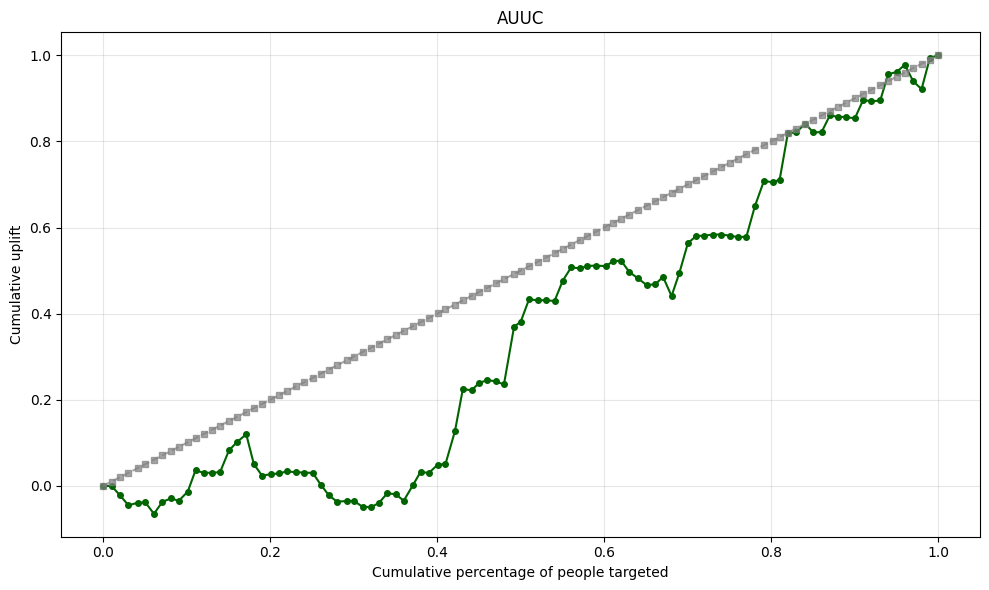

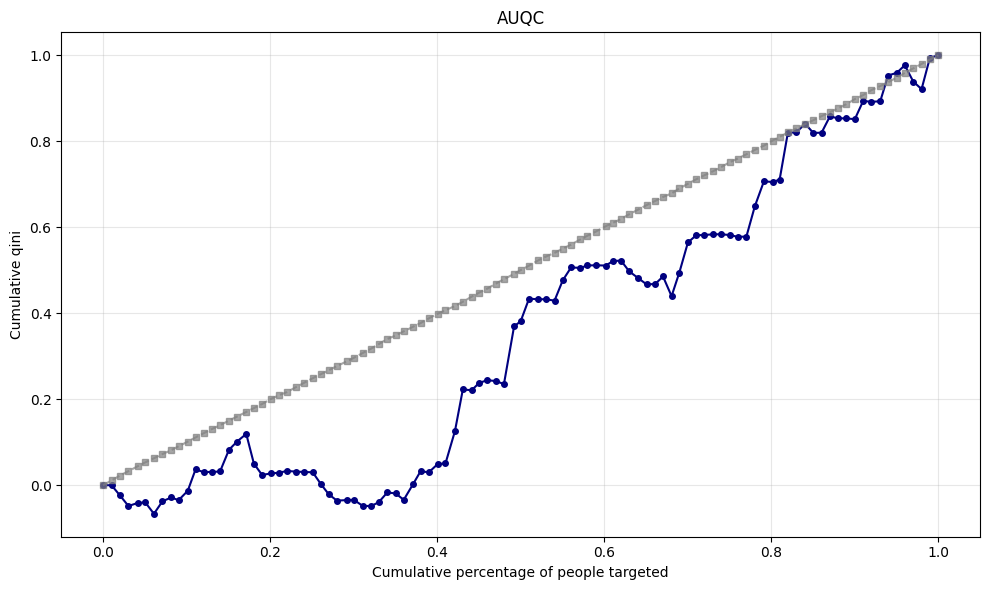

----------------------------------------
AUUC:  0.3545736534588821
AUQC:  0.3540714065865098
Lift:  -0.09288358688354492
KRCC:  -0.10123974582015952
seed: 42


In [ ]:
print ("Evaluating baseline🔃🔃🔃")
# Ensure the input tensor is on the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_men_test_t_on_device = x_men_test_t.to(device)

y0_pred, y1_pred, _,_ = dragonnet.predict(x_men_test_t_on_device)

# Move predicted tensors back to CPU before converting to numpy arrays
uplift_pred = (y1_pred - y0_pred).cpu().numpy().flatten()

y_true = y_men_test_t.cpu().numpy().flatten() # Ensure true labels are also on CPU if they were ever moved
t_true = t_men_test_t.cpu().numpy().flatten() # Ensure true treatments are also on CPU if they were ever moved

auuc_score = auuc(y_true, t_true, uplift_pred, bins=100, plot=True)
auqc_score = auqc(y_true, t_true, uplift_pred, bins=100, plot=True)
lift_score = lift(y_true, t_true, uplift_pred, h=0.3)
krcc_score = krcc(y_true, t_true, uplift_pred, bins= 100)

print ("-"*40)
print ("AUUC: ", auuc_score)
print ("AUQC: ", auqc_score)
print ("Lift: ", lift_score)
print ("KRCC: ", krcc_score)
print (f"seed: {seed}")